In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install pyod
!{sys.executable} -m pip install lightgbm
!{sys.executable} -m pip install catboost 
!{sys.executable} -m pip install plotly 
!{sys.executable} -m pip install seaborn 

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve,plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import gc
gc.enable()

In [121]:
pd.set_option('display.max_rows',100)
pd.set_option('max_columns',None)
pd.set_option('max_colwidth',None)

In [122]:
%%time
posts=pd.read_csv('posts.csv')
comments=pd.read_csv('comments.csv')
post_feed_backs=pd.read_csv('post_feed_back.csv')
post_notice_types=pd.read_csv('post_notice_types.csv')
post_notices=pd.read_csv('post_notices.csv')
post_tags=pd.read_csv('post_tags.csv')
tags = pd.read_csv('tags.csv')
vote_types = pd.read_csv('vote_types.csv')
votes = pd.read_csv('votes.csv')
post_types = pd.read_csv('post_types.csv')

Wall time: 217 ms


In [123]:
posts

Id  PostTypeId  AcceptedAnswerId  ParentId    CreationDate  \
0     20693516           1        20693597.0       NaN  19-12-13 23:12   
1     22513893           1        23056484.0       NaN  19-03-14 17:39   
2     22987482           1               NaN       NaN  10-04-14 12:04   
3     24787801           1        24830938.0       NaN  16-07-14 18:10   
4     25595492           1        27284232.0       NaN  31-08-14 19:26   
...        ...         ...               ...       ...             ...   
6247  64394164           1               NaN       NaN  16-10-20 17:58   
6248  64400350           1               NaN       NaN   17-10-20 8:11   
6249  64401151           1               NaN       NaN   17-10-20 9:51   
6250  64403282           1               NaN       NaN  17-10-20 13:59   
6251  64409379           1               NaN       NaN   18-10-20 3:16   

      DeletionDate  Score  ViewCount  \
0              NaN      6       3390   
1              NaN     21       5316   
2              NaN      8       2671   
3              NaN      3       8884   
4              NaN     51      20873   
...            ...    ...        ...   
6247           NaN      1         31   
6248           NaN      1         15   
6249           NaN      0         20   
6250           NaN      0         17   
6251           NaN      0          7   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [135]:
%%time
print('filter with post type id')
posts.loc[posts['PostTypeId']==1]
print(posts.size)

print('filter with posts with answers')
posts_with_answers =  posts.loc[ posts['AcceptedAnswerId'].notnull()]
print(posts_with_answers.size)

print('filter with posts with no answers')
posts_with_no_accepted_answers = posts.loc[posts['AcceptedAnswerId'].isnull()]
print(posts_with_no_accepted_answers.size)

print('filter with answer count>1')
posts_with_answer_count = posts.loc[posts['AnswerCount'] > 0]
print(posts_with_answer_count.size)

print('filtering with posts having no answers and answer acount>=1')
not_answered_but_answer_count_greater_than_zero = posts.loc[posts['AcceptedAnswerId'].isnull() & posts['AnswerCount']>0]
print(not_answered_but_answer_count_greater_than_zero.size)

filter with post type id
156300
filter with posts with answers
52750
filter with posts with no answers
103550
filter with answer count>1
118700
filtering with posts having no answers and answer acount>=1
50325
Wall time: 13 ms


In [82]:
%%time
print(post_tags)

         PostId   TagId        id
0      36265833      81  36265833
1      36265833     116  36265833
2      36265833   73308  36265833
3      36265833   77128  36265833
4      36265833  106654  36265833
...         ...     ...       ...
23989  64313485  106654  64313485
23990  64314515     116  64314515
23991  64314515   90304  64314515
23992  64314515  106338  64314515
23993  64314515  106654  64314515

[23994 rows x 3 columns]
Wall time: 2.01 ms


In [64]:
%%time
# want to find out the posts with tag specific clustering


post_tags_data_for_clustering = post_tags.loc[:,['PostId','TagId']]
print(post_tags_data_for_clustering.head())


     PostId   TagId
0  36265833      81
1  36265833     116
2  36265833   73308
3  36265833   77128
4  36265833  106654
Wall time: 3 ms


Wall time: 21 ms


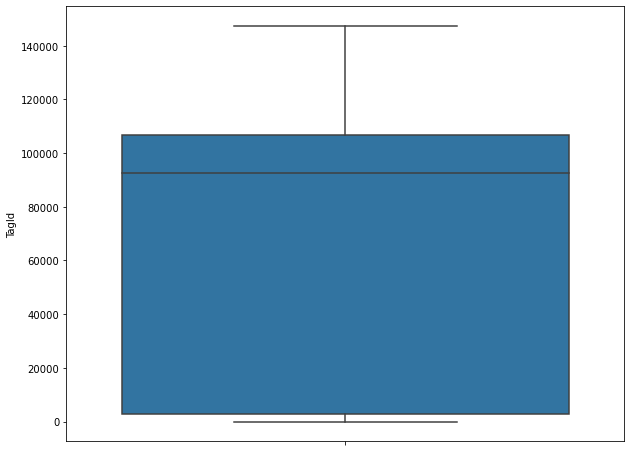

In [74]:
%%time

# remove outliers

fig, ax = plt.subplots(figsize=(10,8))

sns.boxplot(post_tags['TagId'], orient='v')

Wall time: 20 ms


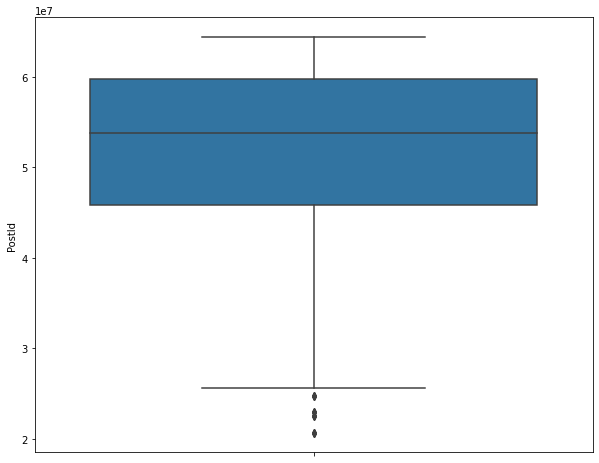

In [75]:
%%time

# remove outliers

fig, ax = plt.subplots(figsize=(10,8))

sns.boxplot(post_tags['PostId'], orient='v')

[Text(0, 0, 'PostId'), Text(0, 0, 'TagId')]

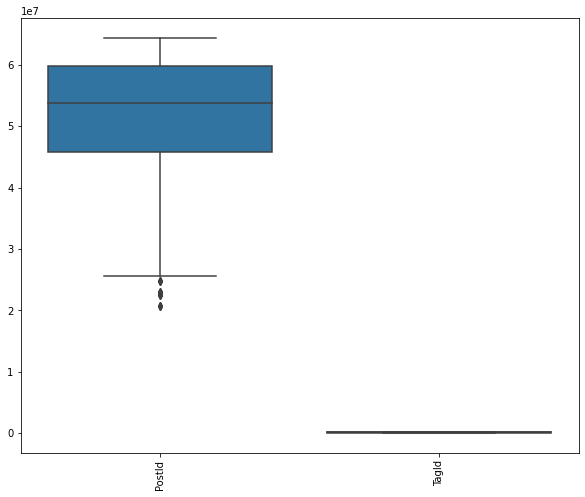

In [76]:
fig, ax = plt.subplots(figsize=(10,8))

bp = sns.boxplot(data = post_tags)

bp.set_xticklabels(bp.get_xticklabels(), rotation=90)

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_array = scaler.fit_transform(post_tags)

In [84]:
scaled_data = pd.DataFrame(scaled_array, columns = post_tags)


ValueError: Index data must be 1-dimensional

In [53]:
%%time
# mean-shift-clustering
from sklearn.cluster import MeanShift, estimate_bandwidth

analyzer = MeanShift(bandwidth=5000)
analyzer.fit(post_tags_data_for_clustering)

Wall time: 23.7 s


MeanShift(bandwidth=5000)

In [48]:
%%time
# mean-shift-clustering
from sklearn.cluster import MeanShift, estimate_bandwidth

estimate_bandwidth(post_tags_data_for_clustering)

Wall time: 25.2 s


5376833.458647006

In [54]:
labels = analyzer.labels_
np.unique(labels)

array([    0,     1,     2, ..., 11817, 11818, 11819], dtype=int64)

In [57]:
%%time

post_tags_data_for_clustering['cluster_group'] = np.nan
data_length = len(post_tags_data_for_clustering)

for i in range(data_length):
    post_tags_data_for_clustering.iloc[i, post_tags_data_for_clustering.columns.get_loc('cluster_group')] = labels[i]

Wall time: 6.01 s


In [58]:
post_tags_data_for_clustering.head()

,PostId,TagId,cluster_group
0,36265833,81,4464.0
1,36265833,116,4464.0
2,36265833,73308,4463.0
3,36265833,77128,4463.0
4,36265833,106654,11141.0


In [59]:
post_tags_data_for_clustering.describe()

,PostId,TagId,cluster_group
count,2.399400e+04,23994.000000,23994.000000
mean,5.214900e+07,64602.667667,3629.076602
std,8.979684e+06,48950.559154,3411.539195
min,2.069352e+07,1.000000,0.000000
25%,4.584812e+07,2990.000000,795.000000
50%,5.382482e+07,92497.000000,2395.000000
75%,5.976461e+07,106654.000000,5859.750000
max,6.440938e+07,147287.000000,11819.000000
